<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#By-using-the-scripting-interface" data-toc-modified-id="By-using-the-scripting-interface-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>By using the scripting interface</a></span><ul class="toc-item"><li><span><a href="#Time-varying-signal" data-toc-modified-id="Time-varying-signal-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Time varying signal</a></span></li><li><span><a href="#Steady-signal" data-toc-modified-id="Steady-signal-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Steady signal</a></span></li></ul></li><li><span><a href="#Using-the-function-library" data-toc-modified-id="Using-the-function-library-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Using the function library</a></span><ul class="toc-item"><li><span><a href="#Time-varying-signal" data-toc-modified-id="Time-varying-signal-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Time varying signal</a></span></li><li><span><a href="#Steady-signal" data-toc-modified-id="Steady-signal-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Steady signal</a></span></li></ul></li></ul></div>


# How to compute tone-to-noise and prominence ratios

This tutorial explains how to use MOSQITO to compute the TNR and PR, indicating the proeminence of tonal components in a signal. Two approaches are possible: scripting interface and function library. The users who just need to compute SQ metrics should preferably use the scripting interface approach. The function library approach is dedicated to users who would like to integrate MOSQITO functions in another software for instance.

In this tutorial, only the TNR results are plotted for the time-varying signals. The PR plots can be obtained by the exact same way just by replacing "tnr" by "pr".


## By using the scripting interface
### Time varying signal
An Audio object is first created by importing an audio file. In this example, the signal is imported from a .wav file. The tutorial [how to import a signal](./tuto_import_signal.ipynb) gives more information about the syntax of the import and the other supported file types. Check the tutorial [Audio signal basic operations](./signal_basic_operations.ipynb) to learn how to plot the time signal, compute and plot its 1/3 octave band spectrum, compute its overall level, etc.



In [1]:
# Add MOSQITO to the Python path
import sys
sys.path.append('..')

# Import MOSQITO color sheme [Optional]
from mosqito import COLORS

# Import Audio class
from mosqito.classes.Audio import Audio

# Create an Audio object
test_signal = Audio(
    "../mosqito/tests/tonality_tnr_pr/white_noise_442_1768_Hz_varying.wav",
    calib=0.01
)

Signal resampled to 48 kHz to allow calculation.


The TNR and PR are computed at one time using the following command line. The function takes 2 input arguments: 
- "method", that can be set to "tnr", "pr", or "all" to compute both,
- "prominence", that indicates if the outputs are either only the prominent values or all tonal values.

The tonal candidates are automatically detected using the Sottek method (see the corresponding [documentation](../documentation/tone-to-noise-prominence-ratio.md) for more information) 

In [2]:
test_signal.compute_tnr_pr(method='all',prominence=True)

[work in progress]

*The preceeding command computes both the TNR and PR of the audio signal as a function of frequency and time. Their value can be plotted with the following command. The "freqs" and "time" arguments indicate the axis over which the values should be plotted. The is_switch_axis argument is used to create a conventional plot with time on the x-axis and frequency on the y-axis. The is_2D_view argument implies the use of a colorbar for the tonality value in dB.*

In [1]:
#test_signal.tonality["tnr"].plot_3D_Data(
#        "freqs",
#        "time",
#        is_switch_axes=True,
#        is_2D_view=True,
#    )


### Steady signal
For a steady signal, the syntax is almost equivalent, see below.

In [5]:
# Create an Audio object
steadynoise = Audio(
    "../mosqito/tests/tonality_tnr_pr/white_noise_442_1768_Hz_stationary.wav",
    calib=0.01,
    is_stationary=True
)

# Compute TNR and PR 
steadynoise.compute_tnr_pr(method="all",prominence=True)

# Print the results
print("Tone-to-noise ratio:" , steadynoise.tonality["tnr"].values , "dB at", steadynoise.tonality["tnr"].axes[0].values, "Hz")
print("T-TNR:", steadynoise.tonality["ttnr"],"dB")
print("Prominence ratio:" , steadynoise.tonality["pr"].values , "dB at", steadynoise.tonality["pr"].axes[0].values, "Hz")
print("T-PR:", steadynoise.tonality["tpr"],"dB")


Signal resampled to 48 kHz to allow calculation.
Tone-to-noise ratio: [31.40178392 26.8806489 ] dB at [ 442 1768] Hz
T-TNR: 32.715053586050644 dB
Prominence ratio: [30.72207589 26.83739332] dB at [ 442 1768] Hz
T-PR: 32.21328086526112 dB


## Using the function library
### Time varying signal
The commands below shows how to compute the TNR and PR of a time varying signal by directly using the functions from MOSQITO. 

Signal resampled to 48 kHz to allow calculation.


([<matplotlib.axis.XTick at 0x26fead05eb0>,
 [Text(0, 0, '0'),
  Text(0, 0, '0.5'),
  Text(0, 0, '1'),
  Text(0, 0, '1.5'),
  Text(0, 0, '2'),
  Text(0, 0, '2.5'),
  Text(0, 0, '3')])

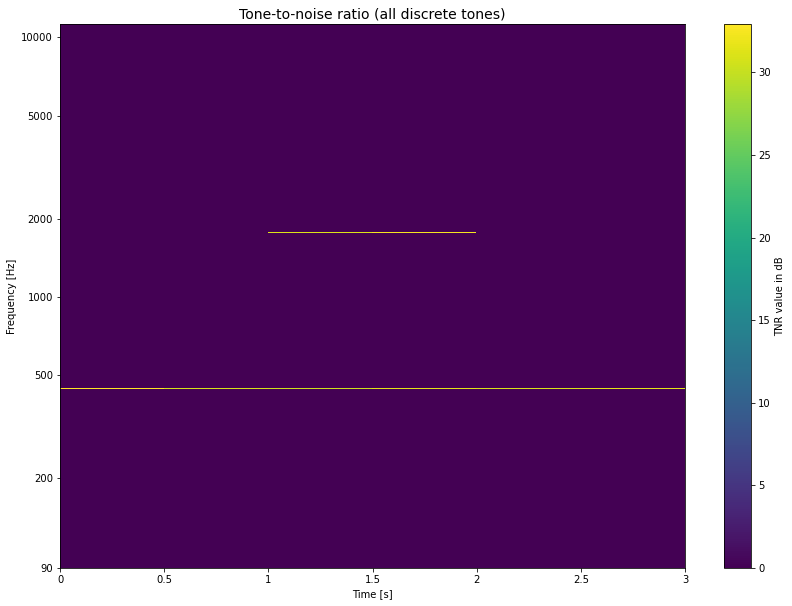

In [6]:
# Import useful packages
import numpy as np
import matplotlib.pyplot as plt
import math

# Import MOSQITO functions
from mosqito.functions.shared.load import load
from mosqito.functions.tonality_tnr_pr.comp_tnr import comp_tnr
from mosqito.functions.tonality_tnr_pr.comp_pr import comp_pr

# Load signal 
signal, fs = load(
    False,
    "../mosqito/tests/tonality_tnr_pr/white_noise_442_1768_Hz_varying.wav",
    calib=0.01
)

# TNR calculation
tnr = comp_tnr(False, signal, fs, prominence=True)

# PR calculation
pr = comp_pr(False, signal, fs, prominence=True)

# Plot
plt.figure(figsize=(14,10))
plt.pcolormesh(tnr["values"], vmin=0)
plt.colorbar(label = "TNR value in dB")
plt.title("Tone-to-noise ratio (all discrete tones)", fontsize=14)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
freq_axis = np.logspace(np.log10(90),np.log10(11200),num=1000)
freq_labels = [90,200,500,1000,2000,5000,10000]
freq_ticks = []
for i in range(len(freq_labels)):
        freq_ticks.append(np.argmin(np.abs(freq_axis - freq_labels[i])))
plt.yticks(freq_ticks, labels=[str(elem) for elem in freq_labels])
nb_frame = math.floor(signal.size / 0.5*fs)
plt.xticks([0,1,2,3,4,5,6],labels=["0","0.5","1","1.5","2","2.5","3"])

### Steady signal
The commands below shows how to compute the TNR and PR of a steady signal by directly using the functions from MOSQITO. 

In [7]:
# Add MOSQITO to the Python path
import sys
sys.path.append('..')

# Import useful packages
import math
import numpy as np
from numpy.fft import fft
import matplotlib.pyplot as plt

# Import MOSQITO modules
from mosqito.functions.shared.load import load
from mosqito.functions.shared.conversion import amp2db
from mosqito.functions.tonality_tnr_pr.comp_tnr import comp_tnr
from mosqito.functions.tonality_tnr_pr.comp_pr import comp_pr

For this tutorial, the test signal .wav file has been generated adding 2 sin tones at 442Hz and 1768Hz to a white noise at 80 dB.

The signal is loaded using the "load" function which takes 3 parameters:

- The signal type as a boolean: True since the signal is stationary
- The path to the .wav signal file: 
- A calibration factor for the signal to be in Pa: 1

Signal resampled to 48 kHz to allow calculation.


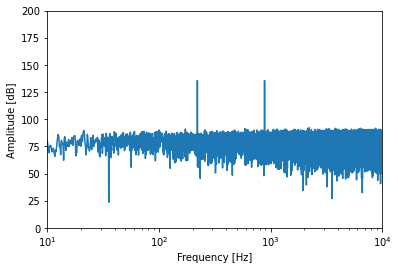

In [8]:
# Load signal and compute third-octave spectrum
signal, fs = load(True,r"../mosqito/tests/tonality_tnr_pr/white_noise_442_1768_Hz_stationary.wav", calib=0.01) 
n = len(signal)

# Plot the signal spectrum
freqs = np.linspace(0, fs/2, n)
spectrum = amp2db(abs(fft(signal * np.blackman(n))) , ref=0.00002)
plt.plot(freqs, spectrum)
plt.xscale('log')
plt.xlim(10,10000)
plt.ylim(0,200)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [dB]")
plt.show()

The spectrum obviously shows a high-level tonal component.

To study this tonal component, the functions "comp_tnr" and "comp_pr" are then used with 4 parameters:

- The signal type (stationary / non-stationary),
- The signal values,
- The sampling frequency,
- The prominence criteria (if True the algorithm only returns the prominent values according to ECMA 74)


The scripts calculates the ratios in dB and returns both the total and individual values (with specification of the tonal frequency). There is no need to enter the frequency of the potential tonal components, the algorithm automatically detects them according to Sottek method.

In [9]:
# Tone-to-noise Ratio calculation
tnr = comp_tnr(True, signal, fs, prominence=True)
# Prominence Ratio calculation
pr = comp_pr(True, signal, fs, prominence=True)

# print the results
print("Tone-to-noise ratio:" , tnr['values'] , "dB at", tnr['freqs'], "Hz")
print("T-TNR:", tnr['global value'],"dB")
print("Prominence ratio:" , pr['values'] , "dB at", pr['freqs'], "Hz")
print("T-PR:", pr['global value'],"dB")


Tone-to-noise ratio: [31.40178392 26.8806489 ] dB at [ 442 1768] Hz
T-TNR: 32.715053586050644 dB
Prominence ratio: [30.72207589 26.83739332] dB at [ 442 1768] Hz
T-PR: 32.21328086526112 dB


The results can also be plotted, with the prominence limit to indicate either the tones are proeminent or not.

([<matplotlib.axis.XTick at 0x26fe9381640>,
 [Text(0, 0, '100'),
  Text(0, 0, '442'),
  Text(0, 0, '1000'),
  Text(0, 0, '1768'),
  Text(0, 0, '10000')])

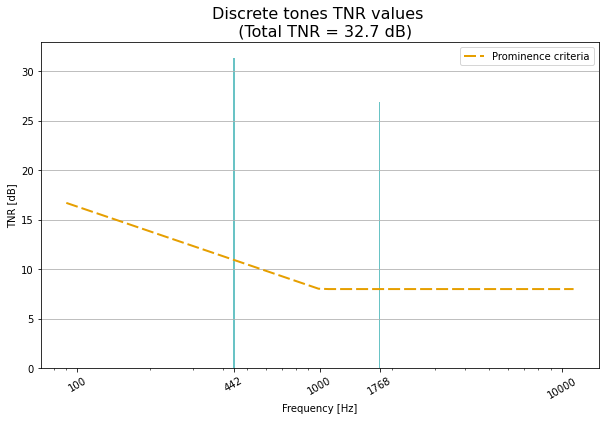

In [10]:
# Prominence criteria
freqs = np.arange(90,11200,100)
limit = np.zeros((len(freqs)))
for i in range(len(freqs)):
    if freqs[i] >= 89.1 and freqs[i] < 1000:
        limit[i] = 8 + 8.33 * np.log10(1000/freqs[i])
    if freqs[i] >= 1000 and freqs[i] < 11200:
        limit[i] = 8 

# Plot
plt.figure(figsize=(10,6))
plt.plot(freqs, limit, color='#e69f00', linewidth=2,dashes=[6,2],label='Prominence criteria')
plt.bar(tnr['freqs'], tnr['values'],width=10, color='#69c3c5')  
plt.legend(fontsize=16)                      
plt.grid(axis='y')
plt.ylabel("TNR [dB]")
            

plt.title("Discrete tones TNR values \n  (Total TNR = "+str(np.around(tnr['global value'],decimals=1))+" dB)", fontsize=16)
plt.legend()

# Frequency axis
plt.xlabel("Frequency [Hz]")
plt.xscale('log')
xticks_pos = [100,1000,10000] + list(tnr['freqs'])
xticks_pos = np.sort(xticks_pos)
xticks_label = [str(elem) for elem in xticks_pos]
plt.xticks(xticks_pos, labels=xticks_label, rotation = 30)   